# Getting Started

## Import Libraries

In [28]:
import boto3
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [29]:
# For OneMap Account Key
from dotenv import load_dotenv
import os
load_dotenv()
account_key = os.getenv('ONEMAP_KEY')

### Starting our AWS Session

In [30]:
session = boto3.Session(profile_name='personal-ltadatamall')
s3 = session.resource('s3')

## Import Dataset from AWS S3

In [31]:
# From AWS S3
dfCombinedFirst = pd.read_parquet(BytesIO(s3.Object('ltadatamall', 'TrainVolume_ProcessedData/Data.parquet').get()['Body'].read()))
dfCombinedSecond = pd.read_parquet(BytesIO(s3.Object('ltadatamall', 'TrainVolumeOrigin_ProcessedData/Data.parquet').get()['Body'].read()))


print(dfCombinedFirst)
print(dfCombinedSecond)



                 DATETIME  DAY_TYPE            PT_NAME  TRAIN_LINES  \
0     2023-08-31 22:00:00         0  Marina South Pier            1   
1     2023-08-31 22:00:00         1  Marina South Pier            1   
2     2023-08-31 00:00:00         1            Stevens            2   
3     2023-08-31 00:00:00         0            Stevens            2   
4     2023-08-31 10:00:00         0        Outram Park            3   
...                   ...       ...                ...          ...   
40900 2024-01-31 06:00:00         0          Bendemeer            1   
40901 2024-01-31 07:00:00         1         Marina Bay            3   
40902 2024-01-31 07:00:00         0         Marina Bay            3   
40903 2024-01-31 12:00:00         0           Ranggung            1   
40904 2024-01-31 12:00:00         1           Ranggung            1   

      TRAIN_CODES        PT_CODE  PT_LATITUDE  PT_LONGITUDE  \
0             [1]           NS28     1.271422    103.863581   
1             [1]    

## Defining Functions

In [43]:
def weekdayOrWeeekend(value):
    if (value == 0):
        return "Weekday"
    else:
        return "Weekend/Holiday"
    
def trainLines(values):
    line_map = {
        '0': "East-West Line",
        '1': "North-South Line",
        '2': "North-East Line",
        '3': "Circle Line",
        '4': "Downtown Line",
        '5': "Thomson-East Coast Line",
        '6': "Bukit Panjang LRT",
        '7': "Sengkang LRT",
        '8': "Punggol LRT"
    }
    return [line_map[str(value)] for value in values if str(value) in line_map]


   

## Analyzing our data

## Finding out the most tapped in location

In [44]:
highestTapInValue = dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].max()
highestTapInLocation = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].idxmax(), 'PT_NAME']
highestTapInTime = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].idxmax(), 'DATETIME']
trainLinesList = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].idxmax(), 'TRAIN_CODES']
dayOfWeek = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_IN_VOLUME'].idxmax(), 'DAY_TYPE']

print(highestTapInValue)
print(highestTapInTime)
print(highestTapInLocation)
print(trainLines(trainLinesList))
print(weekdayOrWeeekend(dayOfWeek))

390282
2024-01-31 18:00:00
Raffles Place
['East-West Line', 'North-South Line']
Weekday


## Finding out the most tapped out location

In [45]:
highestTapOutValue = dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].max()
highestTapOutTime = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].idxmax(), 'DATETIME']
highestTapOutLocation = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].idxmax(), 'PT_NAME']
trainLinesList = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].idxmax(), 'TRAIN_CODES']
dayOfWeek = dfCombinedFirst.loc[dfCombinedFirst['TOTAL_TAP_OUT_VOLUME'].idxmax(), 'DAY_TYPE']

print(highestTapOutValue)
print(highestTapOutTime)
print(highestTapOutLocation)
print(trainLines(trainLinesList))
print(weekdayOrWeeekend(dayOfWeek))

365071
2024-01-31 08:00:00
Raffles Place
['East-West Line', 'North-South Line']
Weekday


## Plotting our first bar graph

In [46]:
# Convert our column back to datetime format
dfCombinedFirst['DATETIME'] = pd.to_datetime(dfCombinedFirst['DATETIME'])

# Finding sum of tap ins in August on Weekdays
df_Raffles_Aug0 = dfCombinedFirst[(dfCombinedFirst['PT_NAME'] == 'Raffles Place') & (dfCombinedFirst['DAY_TYPE'] == 0) & (dfCombinedFirst['DATETIME'].dt.date == pd.to_datetime('2023-08-31').date())]
sumOfTapInWeekday = df_Raffles_Aug0['TOTAL_TAP_IN_VOLUME'].sum()

# Finding sum of tap ins in August on Weekends/Holidays
df_Raffles_Aug1 = dfCombinedFirst[(dfCombinedFirst['PT_NAME'] == 'Raffles Place') & (dfCombinedFirst['DAY_TYPE'] == 1) & (dfCombinedFirst['DATETIME'].dt.date == pd.to_datetime('2023-08-31').date())]
sumOfTapInWeekend = df_Raffles_Aug1['TOTAL_TAP_IN_VOLUME'].sum()

print("Total Tap In Count in August on Weekdays:", sumOfTapInWeekday)
print("Total Tap In Count in August on Weekdays:", sumOfTapInWeekend)

Total Tap In Count in August on Weekdays: 1343955
Total Tap In Count in August on Weekdays: 190684


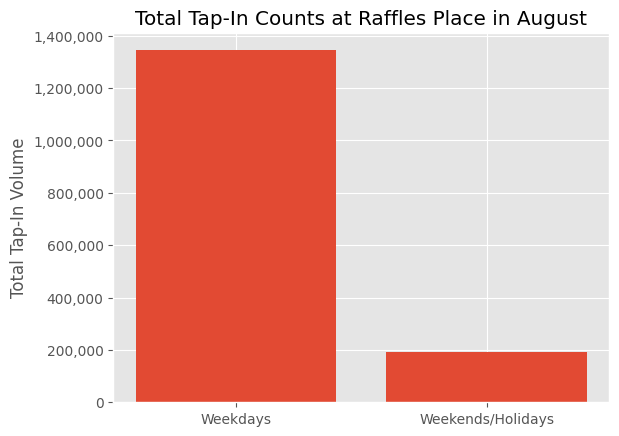

In [47]:
# Data for plotting
categories = ['Weekdays', 'Weekends/Holidays']
values = [sumOfTapInWeekday, sumOfTapInWeekend]

def create_bargraph():
# Plotting the bar graph
    plt.bar(categories, values)

    # Adding title and labels
    plt.title('Total Tap-In Counts at Raffles Place in August')
    plt.ylabel('Total Tap-In Volume')

    # Plotting the graph
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    plt.show()

with plt.style.context("ggplot"):
    create_bargraph()

In [48]:
# Convert our column back to datetime format
dfCombinedFirst['DATETIME'] = pd.to_datetime(dfCombinedFirst['DATETIME'])

# Finding sum of tap ins in August on Weekdays
df_Raffles_Aug0 = dfCombinedFirst[(dfCombinedFirst['PT_NAME'] == 'Bishan') & (dfCombinedFirst['DAY_TYPE'] == 0) & (dfCombinedFirst['DATETIME'].dt.date == pd.to_datetime('2023-08-31').date())]
sumOfTapInWeekday = df_Raffles_Aug0['TOTAL_TAP_IN_VOLUME'].sum()

# Finding sum of tap ins in August on Weekends/Holidays
df_Raffles_Aug1 = dfCombinedFirst[(dfCombinedFirst['PT_NAME'] == 'Bishan') & (dfCombinedFirst['DAY_TYPE'] == 1) & (dfCombinedFirst['DATETIME'].dt.date == pd.to_datetime('2023-08-31').date())]
sumOfTapInWeekend = df_Raffles_Aug1['TOTAL_TAP_IN_VOLUME'].sum()

print("Total Tap In Count in August on Weekdays:", sumOfTapInWeekday)
print("Total Tap In Count in August on Weekdays:", sumOfTapInWeekend)

Total Tap In Count in August on Weekdays: 983730
Total Tap In Count in August on Weekdays: 305830
